## IMPORTATION OF THE REQUIRED LIBRARIES

In [33]:
import yaml 
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from PIL import Image
import datetime

## READING OF THE YAML FILE

In [34]:
with open('config.yaml') as f :
    config = yaml.load(f, Loader=yaml.FullLoader)

## FUNCTIONS 

In this section, we created some functions that will be useful in the uncomming part of our work. <br/> 
Check the readme file for more information.

In [35]:
def build_image_database(path, target): 
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path): path pattern to read csv file containing images information.
  target (str): name of the target column.

  Returns
  -------
  A pandas dataframe, including target class and path to image.
  """
  _df = pd.read_csv(path, sep='\t',
              names=['all'],
              dtype={'all': str},              # ids are not int but string
            )

  # La fonction split() découpe une chaîne de caractères
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

  # La fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

  return _df.drop(columns=['all'])

In [36]:
def show_image(df, row, target):
  """Show an image from an image database, with the associated class.

  Parameters
  ----------
  df (pd.DataFrame): images definition dataframe
  row (int): row index in df of image to be displayed
  target (str): name of the target column

  Returns
  -------
  None
  """
  assert target in df.columns, "Missing target column in dataframe"
  assert 'path' in df.columns, "Missing image path in dataframe"
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))
  return

In [37]:
def load_resize_image(path, height, width):
  """Load an image and resize it to the target size.

  Parameters
  ----------
  path (Path): access path to image file
  height (int): resize image to this height
  width (int): resize image to this width
  
  Returns
  -------
  np.array containing resized image
  """
  return np.array(Image.open(path).resize((width, height)))

In [38]:
def build_x_and_y(df: pd.DataFrame, target: str, images: str):
  """Build x tensor and y tensor for model fitting.

  Parameters
  ----------
  df (pd.DataFrame): dataframe containing images and target
  target (str): name of target column
  images (str): name of images column

  Returns
  -------
  x (np.array): tensor of x values
  y (np.array): tensor of y values
  """
  x = np.array(df[images].to_list())
  y = tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
  return x, y

In [39]:
def build_classification_model(df: pd.DataFrame, target: str, images: str):
  """Build a TF model using information from target and images columns in dataframe.

  Parameters
  ----------
  df (pd.DataFrame): dataframe with target and images columns
  target (str): column name for target variable
  images (str): column name for images

  Returns
  -------
  TF model built & compiled
  """
  nb_classes = df[target].nunique() # Compute number of classes for output layer
  size = df[images].iloc[0].shape # Compute images size for input layer

  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=size))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(nb_classes, activation='softmax')) # output layer with nb_classes

  #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [40]:
def save_model(model, basename):
    
    """
    Save tf/Keras model.

    Model file is named model + timestamp. / save also the classification labels in a txt file

    Parameters
    ----------
    model (tf/Keras model): model to be saved
    basename: location to save model file
    """

    date = datetime.datetime.now()
    model_name = config['MODEL_DIR']+'/'+config['TARGET_NAME']+'/'+'{}_{}.h5'.format(basename, date.strftime('%Y-%m-%d_%H-%M-%S'))
    model.save(model_name)
    
    
    #save target name 
    targets = list(test_df[config['TARGET_NAME']].astype('category').cat.categories.values)
    output_file = open( model_name.replace('.h5','_target.txt') , 'w')
    for target in targets:
        output_file.write( target+'\n')
    output_file.close()
    
    print('### THE MODEL AND HIS TARGETS NAME HAS BEEN SUCCESSFULLY SAVED ##')
    return 

In [41]:
def classify_images(images, model, classes_names=None):
    """Classify images through a TF model.
    Parameters
    ----------
    images (np.array): set of images to classify
    model (tf.keras.Model): TF/ Keras model
    classes_names: dictionnary with classes names
    Returns
    -------
    predicted classes
    """

    results = model.predict(images) # predict for images
    classes = np.argmax(results, axis=1) # np.argmax returns the index of the max value per row
    if classes_names is not None:
        classes = np.array(classes_names[classes])
    return classes

## FIRST ANALYSIS OF THE DATASET

- How to read read some data ? 

In [42]:
df = build_image_database(
    config['DATA_DIR']+'/'+config['TRAIN_DATA_NAME'] , config['TARGET_NAME'] )

In [43]:
df.head(10)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014,Boeing,dataset/data/images/0450014.jpg
5,1042824,Boeing,dataset/data/images/1042824.jpg
6,0894380,Boeing,dataset/data/images/0894380.jpg
7,1427680,Boeing,dataset/data/images/1427680.jpg
8,0817494,Boeing,dataset/data/images/0817494.jpg
9,0716386,Boeing,dataset/data/images/0716386.jpg


- How to display a picture ?

Boeing


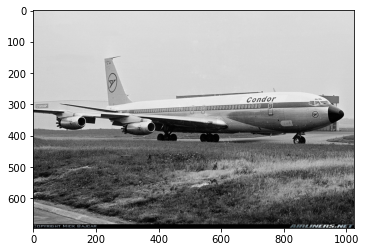

In [44]:
show_image(df,0,config['TARGET_NAME'])

# 1) NEURAL NETWORKS

## TRAINING OF OUR MODEL

- train/test split

In [45]:
# Load train & test dataset
train_df = build_image_database(config['DATA_DIR']+'/'+config['TRAIN_DATA_NAME'], config['TARGET_NAME'])
test_df = build_image_database(config['DATA_DIR']+'/'+config['TEST_DATA_NAME'], config['TARGET_NAME'] )

# Load & resize images
train_df['resized_image'] = train_df.apply(lambda r: load_resize_image(r['path'],
                                                                       config["IMAGE_HEIGTH"] , config['IMAGE_WIDTH']),
                                           axis=1)



test_df['resized_image'] = test_df.apply(lambda r: load_resize_image(r['path'],
                                                                       config["IMAGE_HEIGTH"] , config['IMAGE_WIDTH']),
                                           axis=1)

# Build tensors for training & testing
X_train, y_train = build_x_and_y(train_df, config['TARGET_NAME'] , 'resized_image')
X_test, y_test = build_x_and_y(test_df, config['TARGET_NAME'] , 'resized_image')


- Trainning of the model 

In [46]:
model = build_classification_model(train_df, config['TARGET_NAME'] , 'resized_image')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 58, 58, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        36928     
                                                      

In [47]:
%%time
epochs = config['EPOCH']
model.fit(X_train, y_train, batch_size=32, epochs=epochs, 
                    validation_data=(X_test, y_test)               )

105/105 [==============================] - 147s 1s/step - loss: 13.1187 - accuracy: 0.1392 - val_loss: 2.9252 - val_accuracy: 0.2226
CPU times: user 13min 3s, sys: 1min 34s, total: 14min 37s
Wall time: 2min 27s


## EVALUATION OF OUR MODEL

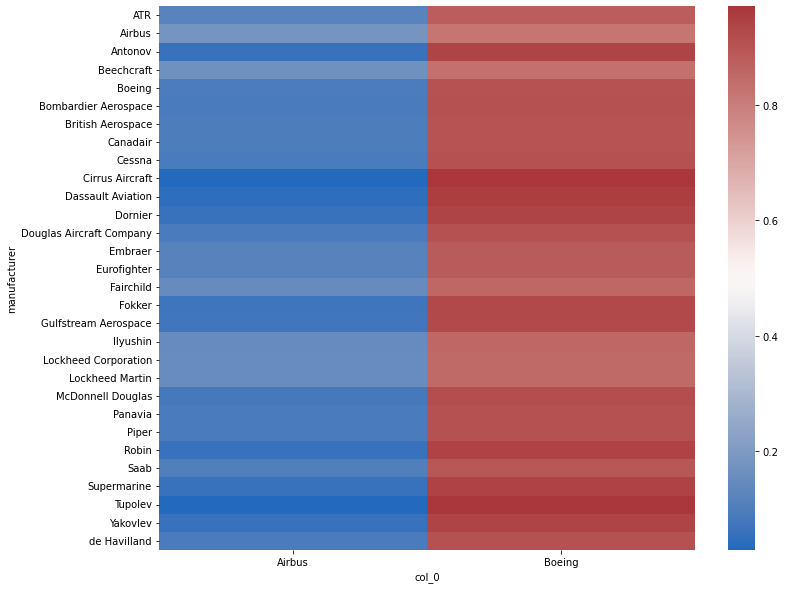

In [48]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(test_df[config['TARGET_NAME']], 
                        classify_images(X_test, model, test_df[config['TARGET_NAME']].astype('category').cat.categories), 
                        normalize='index'),
            cmap='vlag',
            ax=ax)
plt.show()

## SAVING

In [49]:
#Save the model
save_model(model, config['MODEL_NAME'] )

### THE MODEL AND HIS TARGETS NAME HAS BEEN SUCCESSFULLY SAVED ##


## GENERATION OF THE REQUIREMENT.TXT FILE 

In [50]:
#All packges/libraries used in streamlit_app.py
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import yaml 
from PIL import Image
import pandas as pd
from matplotlib.pyplot import style
import os

In [51]:
pip list --format=freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
